Danny's dataset ztf-1a has 3,18,818 systems and light curves in three bands: r,g and i. But when we put the following constrains:
1. System has 2 images only
2. System has over 200 datapoints in light curves in the three bands (r,g,i)
3. Time delay $dt>=10$ days and $0.5<= \mu2/\mu1 <= 2.0$

we have only 433 systems. By visually looking into the light curves of these systems we tested our methods on the following systems which have good looking light curves. 

Here we apply our fitting method based on **template 1 (log-normal) + crossing statistics up to 4th order + stretch** on Danny's dataset (ztf-1a).

In this notebook, **we run longer MCMC chains (using emcee): (most having steps=100,000; burn=15,000).** 
Note that, in this notebook, work on the same systems as in "Applying_Danny_short.ipynb"

In [14]:
%reset -f

In [15]:
import lmfit
import matplotlib.pyplot as plt
import pystan
import emcee
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib
import numpy as np
import corner
plt.rcParams['figure.figsize'] = [12, 8]

In [16]:
import pandas as pd
datapath="/home/users/satadru/lensed_supernovae/data"
fin=datapath+'/ztf-1a.h5'
df1I=pd.read_hdf(fin, 'image')

In [17]:
import sys
def get_mu_dt(sysno):
    print("="*80)
    mu=np.array((df1I[df1I['sysno']==sysn])['mu']);dt=np.array((df1I[df1I['sysno']==sysn])['td'])
    print(df1I[df1I['sysno']==sysn])
    if(len(mu)!=2):
        print("Not a 2-image system...")
        sys.exit()
    
    idx=np.argsort(dt);dt=dt[idx]; mu=mu[idx]
    dt1=dt[1]-dt[0]; mu1=np.abs(mu[1]/mu[0])
    print("\nRelative magnification, mu=",mu1, "time delay dt=",dt1,"\n","="*80)
    return mu1,dt1

In [18]:
#template 1: equ(19)
def mod(x,dt,t0,n,xk,s,c0,c1,c2,c3,c4):    
    mean=n;sig=xk;
    x=x-t0;
    xmax=np.amax(x)
    x=x-dt;
    x=x-s*x;
    #idx=np.where(x<1e-15)[0]
    x[x<1e-15]=1e-16
    fx=(1.0/(sig*np.sqrt(2.0*np.pi)*x))*np.exp(-0.5*(np.log(x)-mean)**2/(sig*sig))
    #fx[idx]=0.0
    
    xs=x/xmax
    #print("len=",len(xs[xs<0.5]))
    fx_mod=fx*(c0+c1*xs+c2*(2.0*xs*xs-1)+c3*(4.0*xs*xs*xs-3.0*xs) + c4*(8.0*xs*xs*xs*xs-8.0*xs*xs+1.0));
    return fx_mod

In [19]:
#with lmfit emcee (MCMC)
p = lmfit.Parameters()
p.add_many(('mu1', 1.0, True, 0.4,2.5),('dt1',5.0, True,0,60.0) ,('t0',0.0, False,0.0,60.0));

p.add_many(('nr', 1.0, True, 0.1,10.0), ('tkr', 0.1, True, 0.0,3.0),('sr', 0.01,True, 0.0,0.99));
p.add_many(('c0r', 1.0, True,None,None),('c1r', 0.1, True, None,None),('c2r', 0.1, True, None,None),
           ('c3r', 0.1, True, None,None) ,('c4r', 0.1,True, None,None))

p.add_many(('ng', 1.0, True, 0.1,10.0), ('tkg', 0.1, True, 0.0,3.0),('sg', 0.01,True, 0.0,0.99))#, ;
p.add_many(('c0g', 1.0, True,None,None),('c1g', 0.1, True, None,None),('c2g', 0.1, True, None,None),
           ('c3g', 0.1,True, None,None) ,('c4g', 0.1,True, None,None))

p.add_many(('nni', 1.0, True, 0.0,10.0), ('tki', 0.1, True, 0.0,3.0),('si', 0.01,True, 0.0,0.99));
p.add_many(('c0i', 1.0, True,None,None),('c1i', 0.1, True, None,None),('c2i', 0.1, True, None,None),
          ('c3i', 0.1, True, None,None),('c4i', 0.1, True, None,None))

#p.add_many(('nz', 1.0, True, 0.1,10.0), ('tkz', 0.10, True, 0.0,3.0),('sz', 0.01,True, 0.0,0.99));
#p.add_many(('c0z', 1.0, True,None,None),('c1z', 0.1, True, None,None),('c2z', 0.1,True, None,None),
#          ('c3z', 0, False, None,None))

def residual(p):
    v = p.valuesdict()
    
    B1=(mod(tr,0,v['t0'],v['nr'],v['tkr'],v['sr'],v['c0r'],v['c1r'],v['c2r'],v['c3r'],v['c4r'])
            +v['mu1']*mod(tr,v['dt1'],v['t0'],v['nr'],v['tkr'],v['sr'],v['c0r'],v['c1r'],v['c2r'],v['c3r'],v['c4r'])-fr)/sigfr;
        
    B2=(mod(tg,0,v['t0'],v['ng'],v['tkg'],v['sg'],v['c0g'],v['c1g'],v['c2g'],v['c3g'],v['c4g'])
            +v['mu1']*mod(tg,v['dt1'],v['t0'],v['ng'],v['tkg'],v['sg'],v['c0g'],v['c1g'],v['c2g'],v['c3g'],v['c4g'])-fg)/sigfg;
    
    B3=(mod(ti,0,v['t0'],v['nni'],v['tki'],v['si'],v['c0i'],v['c1i'],v['c2i'],v['c3i'],v['c4i'])
            +v['mu1']*mod(ti,v['dt1'],v['t0'],v['nni'],v['tki'],v['si'],v['c0i'],v['c1i'],v['c2i'],v['c3i'],v['c4i'])-fi)/sigfi;
    
    #B4=(mod(tz,v['t0'],v['nz'],v['tkz'],v['sz'],v['c0z'],v['c1z'],v['c2z'],v['c3z'],0)
            #+v['mu1']*mod(tz-v['dt1'],v['t0'],v['nz'],v['tkz'],v['sz'],v['c0z'],v['c1z'],v['c2z'],v['c3z'],0)-fz)/sigfz;
    
    return np.concatenate((B1,B2,B3))


p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

In [20]:
import corner
#print(res2.params.valuesdict().values())

def plot_contour(sample,mu_des,dt_des):
    emcee_plot = corner.corner(sample.flatchain[['mu1','dt1']], labels=['mu','dt'],color='g', smooth=1,
                        levels=(0.68,0.95),plot_density=0, fill_contours=1, plot_datapoints=0.000001,
                           truths=list([mu_des,dt_des]))
    plt.show(emcee_plot)

In [21]:
def plot_func(res):
    highest_prob = np.argmax(res.lnprob)
    hp_loc = np.unravel_index(highest_prob, res.lnprob.shape)
    mle_soln = res.chain[hp_loc]
    #[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=data
    #print(mle_soln.shape)
    #sys.exit()
    #for i, par in enumerate(p):
    #p[par].value = mle_soln[i]
    #print(mle_soln[i])
    print("\nMaximum likelihood Estimation")
    print('-----------------------------')
    #print(len(mle_soln))
    t0m=0.0;
    [mum,dtm,
     nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,c4rm,
     ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,c4gm,
     nim,tkim,sim,c0im,c1im,c2im,c3im,c4im,
     lnm]=mle_soln;
    
    #print(mle_soln)
    #print("g-band: ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm=",ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm)
    #mum,dtm=1.4/2.4,15.0
    #print("Maximum liklihood: mu=",mum, "dt=",dtm)
    #sys.exit()
    #print(p)
    Ps1r=mod(tr,0,t0m,nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,c4rm)
    Ps2r=mum*mod(tr,dtm,t0m,nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,c4rm)
    Psr=Ps1r+Ps2r

    
    Ps1g=mod(tg,0,t0m,ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,c4gm)
    Ps2g=mum*mod(tg,dtm,t0m,ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,c4gm)
    Psg=Ps1g+Ps2g

    
    Ps1i=mod(ti,0,t0m,nim,tkim,sim,c0im,c1im,c2im,c3im,c4im)
    Ps2i=mum*mod(ti,dtm,t0m,nim,tkim,sim,c0im,c1im,c2im,c3im,c4im)
    Psi=Ps1i+Ps2i
 

    plt.rcParams['figure.figsize'] = [12, 8]
    plt.title(r'template 1')
    plt.errorbar(tr,fr,yerr=sigfr,fmt='r*',label=r"data r: %s ponits"%(len(tr))) #data
    plt.plot(tr, Psr, c="r")

    
    plt.errorbar(tg,fg,yerr=sigfg,fmt='g*',label=r"data g: %s ponits"%(len(tg))) #data
    plt.plot(tg, Psg, c="g")
    
    plt.errorbar(ti,fi,yerr=sigfi,fmt='b*',label=r"data b: %s ponits"%(len(ti))) #data
    plt.plot(ti, Psi, c="b")

    plt.legend(loc=0)
    plt.show()
    
    chisqr=np.sum((Psr-fr)**2/sigfr**2); chisqg=np.sum((Psg-fg)**2/sigfg**2);  
    chisqi=np.sum((Psi-fi)**2/sigfi**2);

    print("Maximum liklihood: mu=",mum, "dt=",dtm)
    print("\nChi^2 r=",chisqr,"Chi^2 g=",chisqg,"Chi^2 i=",chisqi)
    print("data points::: r-band:",len(tr)," g-band:",len(tg)," i-band:",len(ti))
    plt.show()
    
    plt.subplot(2, 2, 1)
    plt.title(r'r-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(tr,fr,yerr=sigfr,fmt='r*',label=r"data r") #data
    plt.plot(tr, Psr, c="r")
    plt.plot(tr, Ps1r,c="r",ls="--")
    plt.plot(tr, Ps2r,c="r",ls="dotted")

    
    plt.subplot(2, 2, 2)
    plt.title(r'g-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(tg,fg,yerr=sigfg,fmt='g*',label=r"data g") #data
    plt.plot(tg, Psg, c="g")
    plt.plot(tg, Ps1g,c="g",ls="--")
    plt.plot(tg, Ps2g,c="g",ls="dotted")
    

    
    plt.subplot(2, 2, 3)
    plt.title(r'i-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    t=ti
    plt.errorbar(t,fi,yerr=sigfi,fmt='b*',label=r"data i") #data
    plt.plot(t, Psi, c="b")
    plt.plot(t, Ps1i,c="b",ls="--")
    plt.plot(t, Ps2i,c="b",ls="dotted")

    
    plt.legend(loc=0)
    plt.show()


In [22]:
def read_data(sysn):
    inp_path='../read_data/ztf-1a/'
    bands=['ztfr','ztfg','ztfi']
    fileN='ztf-1a_stackedflux_sysn%s_band_'%(sysn)

    fileNr=inp_path+fileN+bands[0];print(fileNr)
    fileNg=inp_path+fileN+bands[1];print(fileNg)
    fileNi=inp_path+fileN+bands[2];print(fileNi)

    tr,fr,sigfr=np.loadtxt(fileNr,usecols=[0,1,2], unpack=True)
    tg,fg,sigfg=np.loadtxt(fileNg,usecols=[0,1,2], unpack=True)
    ti,fi,sigfi=np.loadtxt(fileNi,usecols=[0,1,2], unpack=True)

    t_mins=np.array([np.amin(tr), np.amin(tg), np.amin(ti)])
    t_maxs=np.array([np.amax(tr), np.amax(tg), np.amax(ti)])
    t_min=np.amin(t_mins)-1e-5; t_max=np.amax(t_maxs);

    # we substract a fixed time, it should not have any effect on the pystan results
    tr=tr-t_min; tg=tg-t_min; ti=ti-t_min; 
    t_max=t_max-t_min; t_min=0.0;

    c=['r','g','b']
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.errorbar(tr,fr,yerr=sigfr,fmt='%s*'%(c[0]),label=r"r-band: %s points"%(len(tr)))
    plt.errorbar(tg,fg,yerr=sigfg,fmt='%s*'%(c[1]),label=r"g-band: %s points"%(len(tg)))
    plt.errorbar(ti,fi,yerr=sigfi,fmt='%s*'%(c[2]),label=r"i-band: %s points"%(len(ti)))
    plt.legend(loc=0)
    plt.show()

    mu_des,dt_des=get_mu_dt(sysn)
    return [tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]

In [23]:
def fitting(sysn,step,burn,thin,nwalker):
    res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=burn, steps=step, thin=thin, 
                         nwalkers=nwalker,params=p, is_weighted=False,seed=20145)
    lmfit.report_fit(res.params,show_correl=False,min_correl=0.9);
    plot_contour(res, mu_des,dt_des)
    plot_func(res)
    return res;

In [24]:
sys_no_list_full1=[14485178,25739652,30168511,30484845,31999299,33603471,36126318,37790873,39087310,
                  40221141,44994746,46459738,47725481,51127319,53345196,55281814,59593933,61550746]

sys_no_list_full2=[62250655,70776641,70861347,71488663,76226169,76277223,77272711,81741581,82320026, 93507840, 94866642
                   ,95598133,96069612, 96640307,98361511]

print(len(sys_no_list_full1),len(sys_no_list_full2))

18 15


**Below we apply template 1 (equ(19)) + stretch + 4th order crossing statistics on the following systems from Danny's datasets**

In [25]:
sys_no_list=[14485178,25739652,30168511,30484845,31999299,33603471,36126318,37790873,39087310,40221141];
Nsys=len(sys_no_list);
print("Total no. of systems to be studied=",Nsys)
results=np.zeros(Nsys,dtype=object)
i=0;

Total no. of systems to be studied= 10


In [26]:
step=100000; burn=15000; nwalker=150; thin=3;


Starting i=0, SystemNo=14485178 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn14485178_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn14485178_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn14485178_band_ztfi


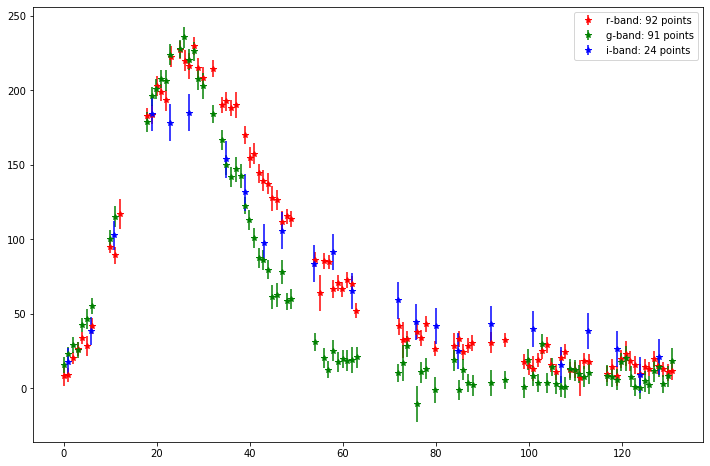

          td         x         y        mu     sysno  imno
0   0.000000  1.630181  0.152337  2.737243  14485178     0
1  11.904629 -0.697078 -0.181198 -2.200877  14485178     1

Relative magnification, mu= 0.8040486811869156 time delay dt= 11.904629079947636 


100%|██████████| 100000/100000 [1:27:43<00:00, 19.00it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 25 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 6566.59325003  1827.79808383  6853.89550321  2429.56721541
  1139.56916617 10783.9528604  10963.78223044 10414.3685397
 11009.55750359 10961.93719013  8778.24205579  5869.77456997
  3491.91806269 10191.17574216 10529.63636832 10297.61071
 10448.59529762 10415.37481599 10502.39387068  9879.90019072
  9370.49824509 10452.32599165 10169.49897365 10516.5106458
 10208.28120019 10504.14052856  8227.97979353]
[[Variables]]
    mu1:        1.46378183 +/- 0.17072598 (11.66%) (init = 1)
    dt1:        12.8513701 +/- 0.36624361 (2.85%) (init = 5)
    t0:         0 (fixed)
    nr:         0.82977191 +/- 0.45760511 (55.15%) (init = 1)
    tkr:        0.85343069 +/- 0.09356334 (10.96%) (init = 0.1)
    sr:         0.93112820 +/- 0.02994762 (3.22%) (init = 0.01)
    c0r:        15024.5625 +/- 87333.5476 (581.27%) (init = 1)
    c1r:   

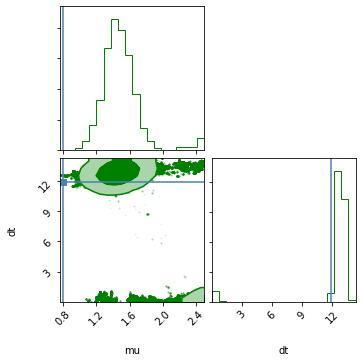


Maximum likelihood Estimation
-----------------------------


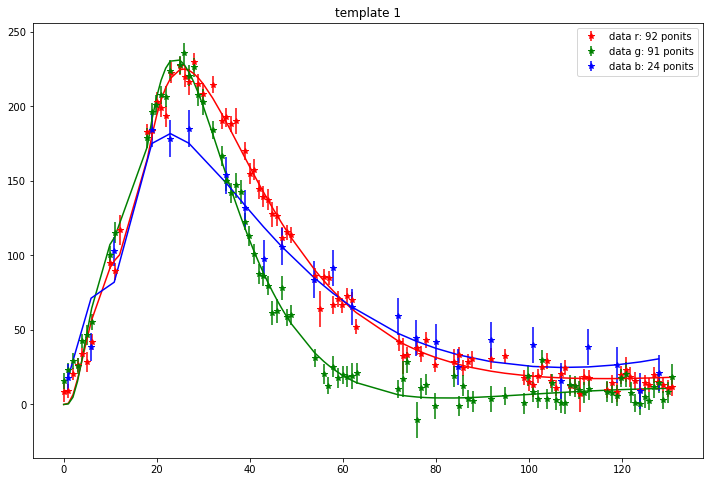

Maximum liklihood: mu= 1.3687070589543975 dt= 12.859402849366603

Chi^2 r= 131.54866015796566 Chi^2 g= 166.21097731748682 Chi^2 i= 31.860219329799136
data points::: r-band: 92  g-band: 91  i-band: 24


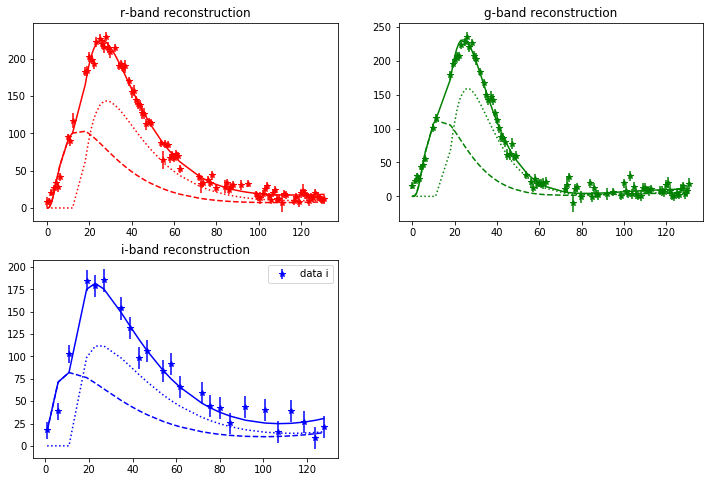

In [27]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=1, SystemNo=25739652 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn25739652_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn25739652_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn25739652_band_ztfi


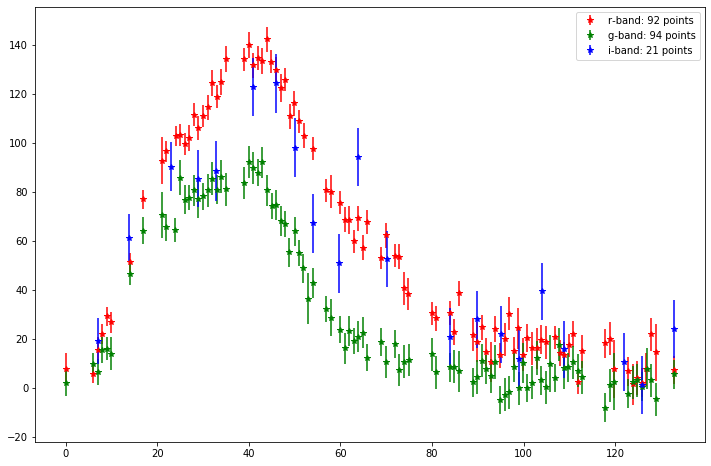

          td         x         y        mu     sysno  imno
0   0.000000 -1.711629 -0.310434  1.620579  25739652     0
1  19.330746  0.396330  0.041350 -1.526407  25739652     1

Relative magnification, mu= 0.9418899199604099 time delay dt= 19.33074629785194 


100%|██████████| 100000/100000 [1:33:09<00:00, 17.89it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 26 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 2661.42185476  2450.19208629  6553.26151399  1052.14968425
  2083.97238775 11210.07762437 11413.1699867  11476.09817012
 11593.80853797 12429.36606677  7632.1867938   5955.93212932
  6942.46486627 11160.187182   11994.76106822 11340.75156651
 11515.29004735 11415.19723375  9446.99051359  8587.51128522
  9229.00666443 11490.07574488 11516.29001521 11378.1991799
 11948.62447554 10948.27417318  5772.91678428]
[[Variables]]
    mu1:        0.75931803 +/- 0.05297190 (6.98%) (init = 1)
    dt1:        19.4507122 +/- 0.49746439 (2.56%) (init = 5)
    t0:         0 (fixed)
    nr:         0.58841633 +/- 0.34601110 (58.80%) (init = 1)
    tkr:        0.58178628 +/- 0.03032899 (5.21%) (init = 0.1)
    sr:         0.94838257 +/- 0.01614410 (1.70%) (init = 0.01)
    c0r:        21867.5268 +/- 46337.9538 (211.90%) (init = 1)
    c1r: 

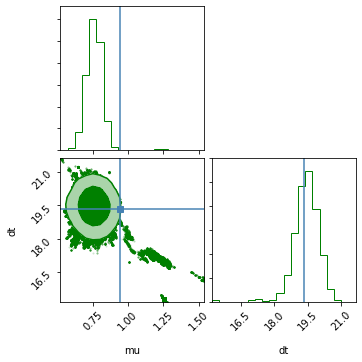


Maximum likelihood Estimation
-----------------------------


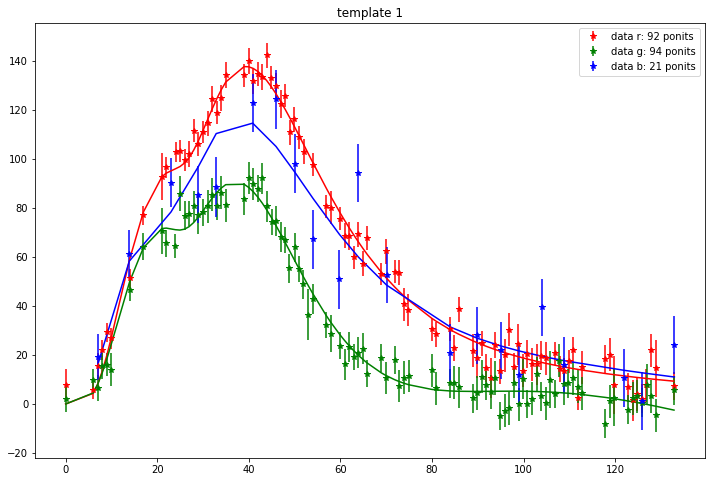

Maximum liklihood: mu= 0.8285354696303198 dt= 19.81564451172584

Chi^2 r= 100.39972911651954 Chi^2 g= 62.089598992674084 Chi^2 i= 28.536256181413187
data points::: r-band: 92  g-band: 94  i-band: 21


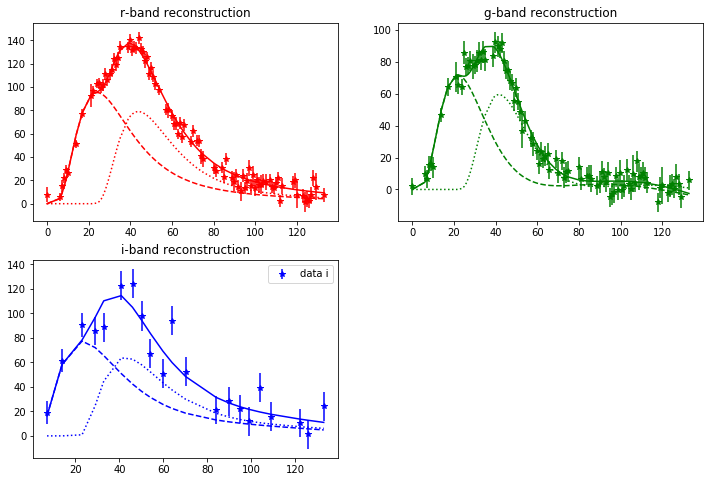

In [28]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=2, SystemNo=30168511 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn30168511_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn30168511_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn30168511_band_ztfi


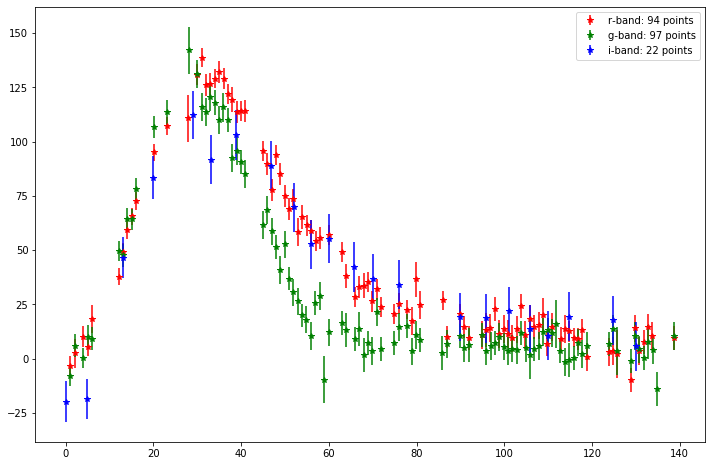

          td         x         y        mu     sysno  imno
0   0.000000  1.084883 -0.788335  2.196579  30168511     0
1  13.882027 -0.269380  0.323795 -1.271387  30168511     1

Relative magnification, mu= 0.57880294374643 time delay dt= 13.882027239987359 


100%|██████████| 100000/100000 [1:22:31<00:00, 20.20it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 25 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 9954.66444221  4183.26655512  7522.22587114  1113.57462535
  1165.32401318 10591.06301467 11129.4917449  10596.81694461
 11100.35610135 11504.14419488  8197.90213707  3938.36501158
  8120.55088845 12513.19226269 11287.72083115 11971.01045511
 11046.53091158 11454.67109308  8919.32389621  8175.72332651
  8588.54946978 10810.73273964 11131.67947593 10415.95405705
 10683.49657199 10668.85548868  9293.93869344]
[[Variables]]
    mu1:        0.66964773 +/- 0.23376038 (34.91%) (init = 1)
    dt1:        12.2642789 +/- 1.19086697 (9.71%) (init = 5)
    t0:         0 (fixed)
    nr:         0.79733146 +/- 0.41238036 (51.72%) (init = 1)
    tkr:        0.58466277 +/- 0.03859322 (6.60%) (init = 0.1)
    sr:         0.93409410 +/- 0.02502620 (2.68%) (init = 0.01)
    c0r:        10793.2309 +/- 49170.2131 (455.57%) (init = 1)
    c1r

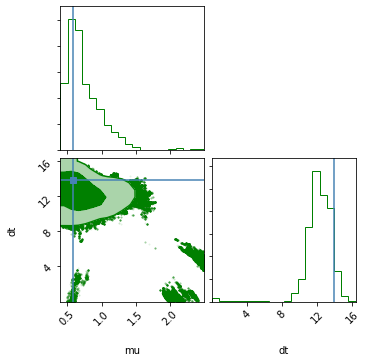


Maximum likelihood Estimation
-----------------------------


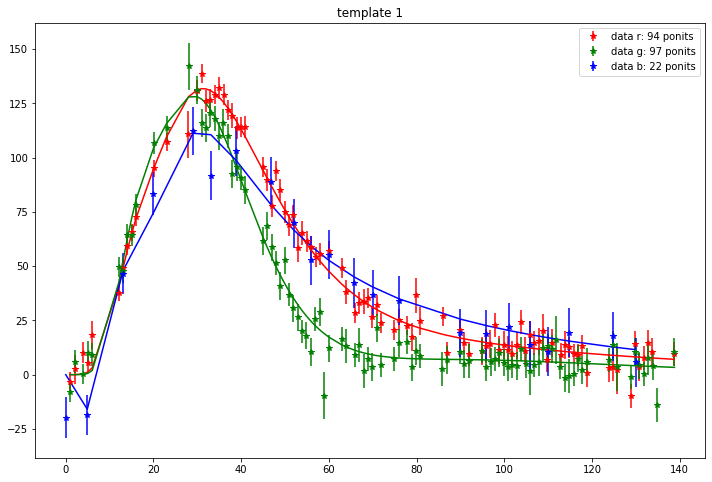

Maximum liklihood: mu= 0.5436951525637198 dt= 13.252355736082103

Chi^2 r= 92.62285047764921 Chi^2 g= 88.53271858876751 Chi^2 i= 11.426519362606971
data points::: r-band: 94  g-band: 97  i-band: 22


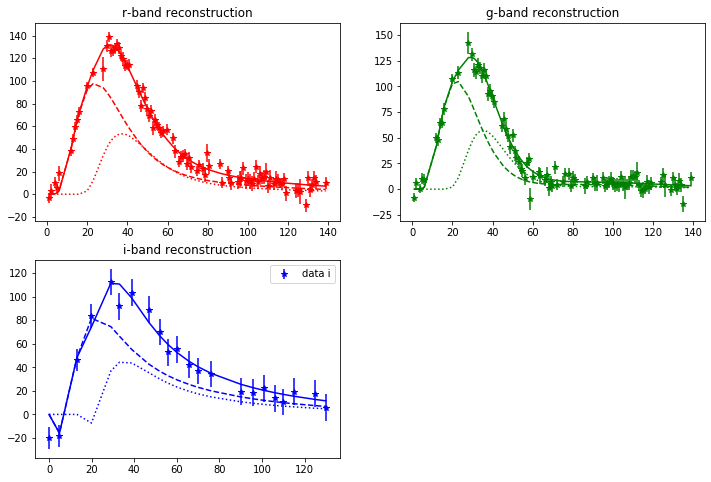

In [29]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=3, SystemNo=30484845 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn30484845_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn30484845_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn30484845_band_ztfi


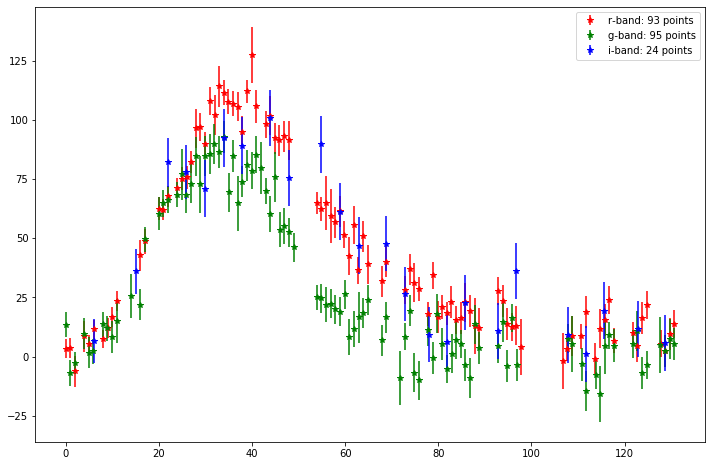

          td         x         y        mu     sysno  imno
0   0.000000  1.513721 -0.502092  2.339680  30484845     0
1  16.324499 -0.431475  0.686232 -2.631509  30484845     1

Relative magnification, mu= 1.1247302162102544 time delay dt= 16.324499046149477 


100%|██████████| 100000/100000 [1:22:48<00:00, 20.13it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 27 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 6045.63706334  4901.02503732  6760.51208586  2648.55464153
  2055.78818478 11361.17261158 11922.47496734 11211.74175881
 11844.11032612 11478.93820799  6505.96909542  5325.93925566
  2924.88062306 11626.51882743 11044.54656082 11308.63786185
 11132.55206318 11060.52104042  8399.58296834  8691.01867975
  8827.58528595 11242.32656217 11573.37707231 11537.18443029
 12021.11315745 11246.69047113  7889.87878567]
[[Variables]]
    mu1:        0.90141345 +/- 0.16940116 (18.79%) (init = 1)
    dt1:        15.1600491 +/- 0.93795232 (6.19%) (init = 5)
    t0:         0 (fixed)
    nr:         1.04391976 +/- 0.57235511 (54.83%) (init = 1)
    tkr:        0.58038298 +/- 0.04549413 (7.84%) (init = 0.1)
    sr:         0.92455446 +/- 0.03577724 (3.87%) (init = 0.01)
    c0r:        18109.1366 +/- 37336.5954 (206.18%) (init = 1)
    c1r

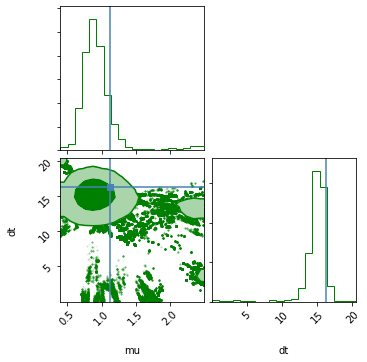


Maximum likelihood Estimation
-----------------------------


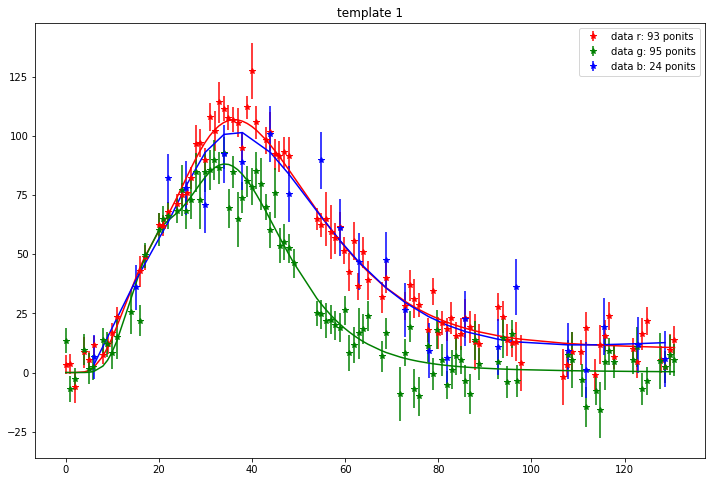

Maximum liklihood: mu= 0.8298629444476264 dt= 15.122140307339954

Chi^2 r= 82.23382711343352 Chi^2 g= 107.68326798597616 Chi^2 i= 23.215026504765994
data points::: r-band: 93  g-band: 95  i-band: 24


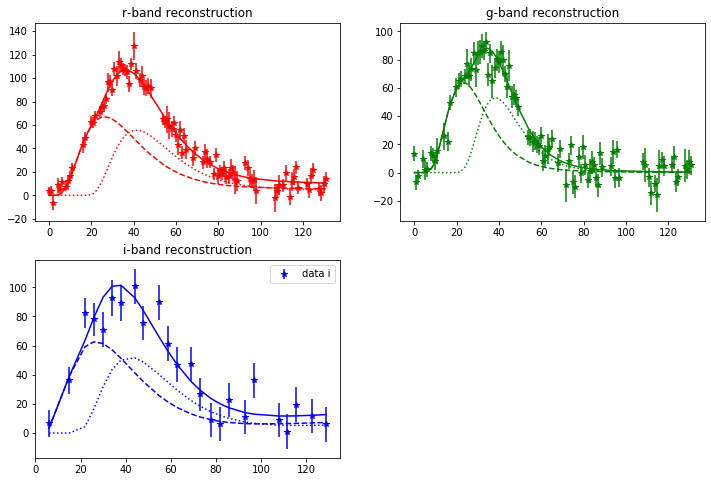

In [30]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=4, SystemNo=31999299 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn31999299_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn31999299_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn31999299_band_ztfi


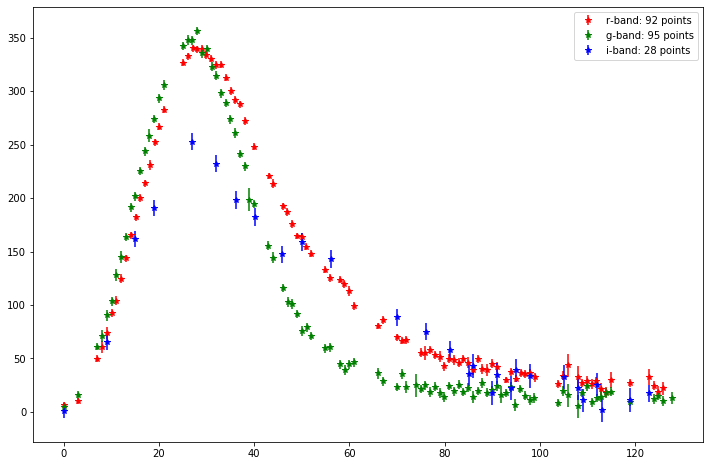

          td         x         y        mu     sysno  imno
0   0.000000  1.191082  0.196777  2.145446  31999299     0
1  10.988325 -0.386674 -0.242519 -1.739422  31999299     1

Relative magnification, mu= 0.8107509292859303 time delay dt= 10.988324861939443 


100%|██████████| 100000/100000 [1:33:24<00:00, 17.84it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 25 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 6684.59370057  2317.14181358  3461.52102679  1607.06291108
  3161.21428016 10939.89038134 11231.15372254 10885.55427604
 11184.37288171 10801.22148269  7580.36816957  5138.94403067
   668.91346072 11267.05778569 11227.31278261 11290.56371119
 11234.26357339 11355.19551994  7024.18363533  8833.46854288
  7775.89627124 11379.58690954 11289.67989584 11408.3723069
 11359.23006265 11207.84639439  9879.0330634 ]
[[Variables]]
    mu1:        0.91178087 +/- 0.06501439 (7.13%) (init = 1)
    dt1:        10.9052522 +/- 0.23442107 (2.15%) (init = 5)
    t0:         0 (fixed)
    nr:         1.35375295 +/- 0.31707908 (23.42%) (init = 1)
    tkr:        0.63076026 +/- 0.02376642 (3.77%) (init = 0.1)
    sr:         0.89277619 +/- 0.03291032 (3.69%) (init = 0.01)
    c0r:        28432.1097 +/- 660226.539 (2322.12%) (init = 1)
    c1r:

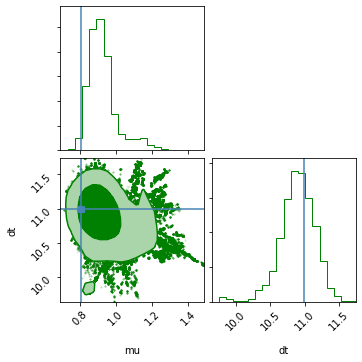


Maximum likelihood Estimation
-----------------------------


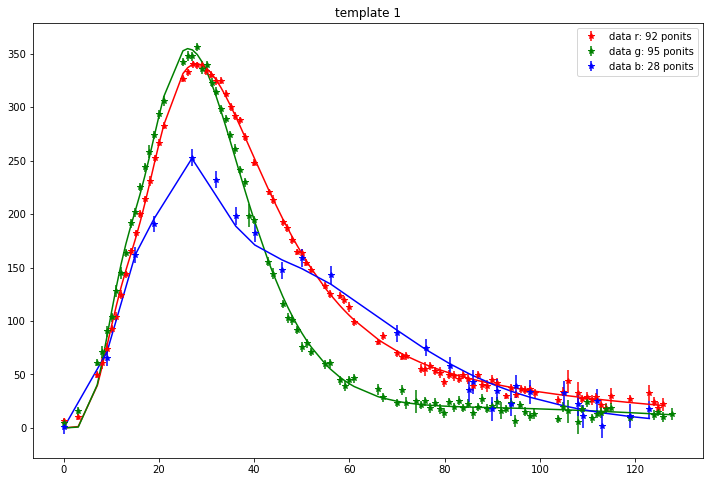

Maximum liklihood: mu= 0.9069681603625783 dt= 10.981547801435902

Chi^2 r= 130.20678989307962 Chi^2 g= 185.04031040182858 Chi^2 i= 25.485813030978974
data points::: r-band: 92  g-band: 95  i-band: 28


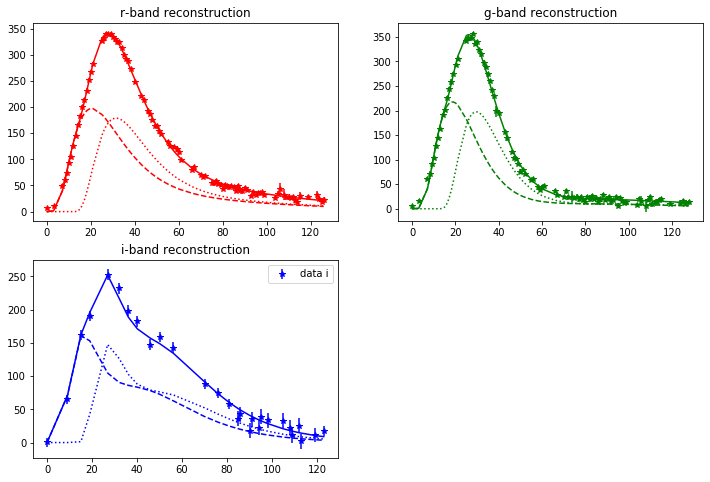

In [31]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=5, SystemNo=33603471 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn33603471_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn33603471_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn33603471_band_ztfi


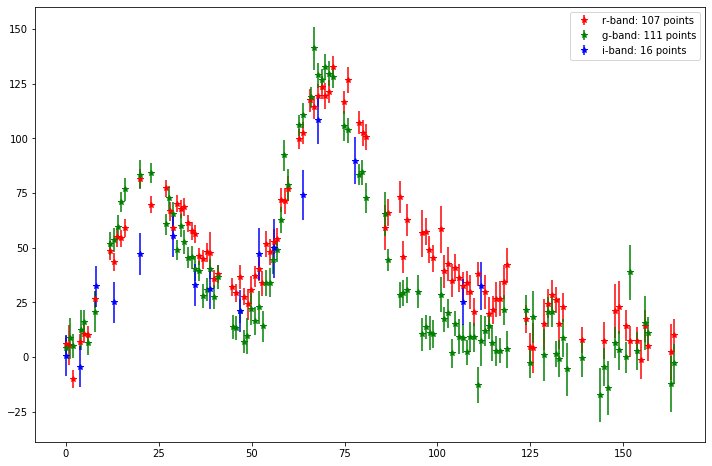

          td         x         y        mu     sysno  imno
0   0.000000  2.723160  3.800971  1.380376  33603471     0
1  47.921368  0.101356 -1.191308 -2.080554  33603471     1

Relative magnification, mu= 1.5072379410091472 time delay dt= 47.9213682556892 


100%|██████████| 100000/100000 [1:02:40<00:00, 26.59it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 25 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 9416.8865137  10325.8749396  12445.39570012 12669.05556477
  1361.22659427 11594.66039478 12429.43302485 11856.52329851
 12463.86714211 12801.74574113 10443.81737956 10585.42027073
  8695.82947375 12600.83946158 12718.6635679  12469.62965581
 12679.32389545 12435.43736685  7568.88553736  6764.76129626
  8947.41228707 12312.5896841  12442.70679782 12702.20919012
 11663.49598089 12231.13477846   118.03517534]
[[Variables]]
    mu1:        1.83801942 +/- 0.70975075 (38.61%) (init = 1)
    dt1:        3.69400470 +/- 5.31632878 (143.92%) (init = 5)
    t0:         0 (fixed)
    nr:         3.99406486 +/- 2.10976676 (52.82%) (init = 1)
    tkr:        1.89461768 +/- 0.73092539 (38.58%) (init = 0.1)
    sr:         0.97542165 +/- 0.01693060 (1.74%) (init = 0.01)
    c0r:       -536930.287 +/- 1848227.16 (344.22%) (init = 1)
    

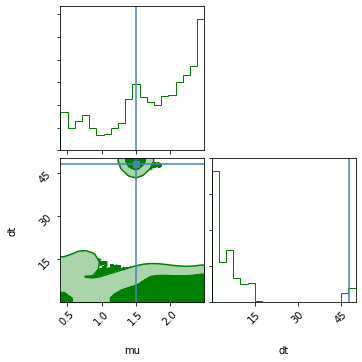


Maximum likelihood Estimation
-----------------------------


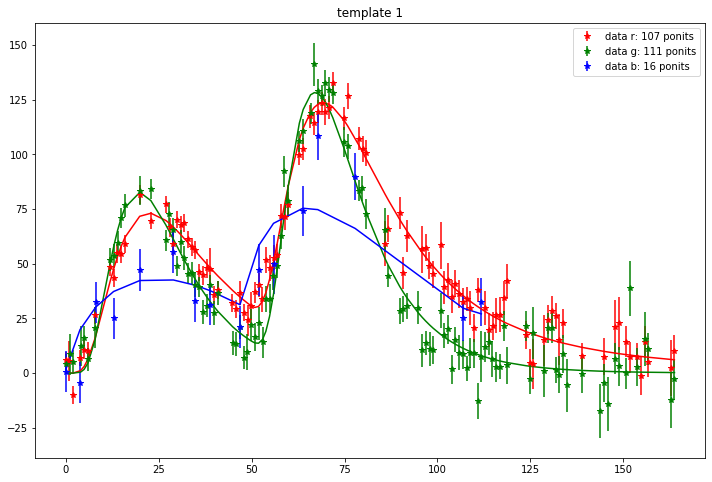

Maximum liklihood: mu= 1.5011664549070767 dt= 47.66469601905068

Chi^2 r= 165.8136426583839 Chi^2 g= 175.26994469701395 Chi^2 i= 30.344913979526755
data points::: r-band: 107  g-band: 111  i-band: 16


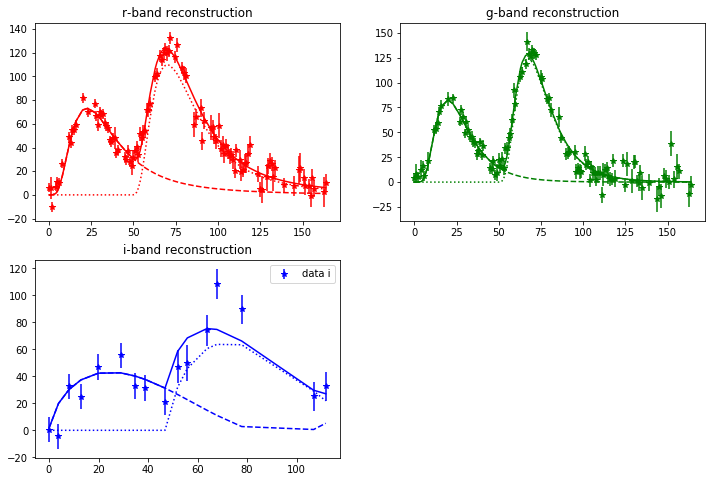

In [32]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=6, SystemNo=36126318 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn36126318_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn36126318_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn36126318_band_ztfi


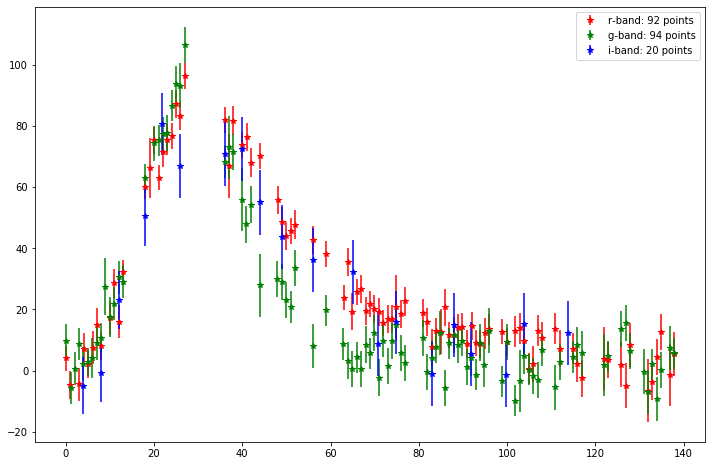

          td         x         y        mu     sysno  imno
0   0.000000  0.093277  1.009812  1.754933  36126318     0
1  10.520587 -0.073127 -0.216610 -1.053575  36126318     1

Relative magnification, mu= 0.6003505788399078 time delay dt= 10.520586892987547 


100%|██████████| 100000/100000 [1:10:06<00:00, 23.77it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 27 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 9637.40287612  5888.56949321  7178.07465315  3654.52247656
  2559.44080121 11390.2409192  11542.71849606 11541.63482722
 11086.48222416 11522.9345139   8440.60423084  6320.68018266
  7850.41752393 11800.34013566 11349.27274009 11828.42942893
 11503.91685379 11732.93096389  8037.53729966  7855.50424708
  8710.98282384 11980.58692001 11568.60213946 11775.81107233
 11145.63743976 11669.08132973  8774.66288895]
[[Variables]]
    mu1:        1.32531784 +/- 0.65328202 (49.29%) (init = 1)
    dt1:        10.2612812 +/- 1.47989797 (14.42%) (init = 5)
    t0:         0 (fixed)
    nr:         0.78374201 +/- 0.53941922 (68.83%) (init = 1)
    tkr:        0.64566776 +/- 0.06580358 (10.19%) (init = 0.1)
    sr:         0.92317659 +/- 0.04570212 (4.95%) (init = 0.01)
    c0r:       -396.712514 +/- 7146.67689 (1801.48%) (init = 1)
    

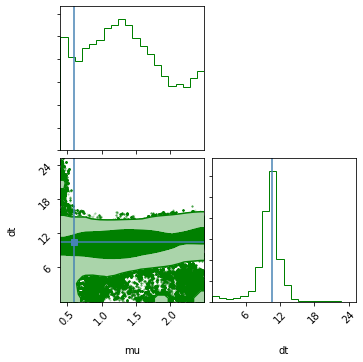


Maximum likelihood Estimation
-----------------------------


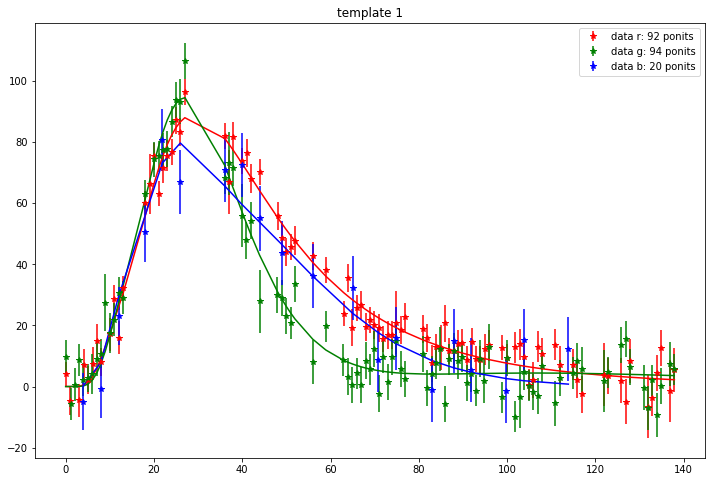

Maximum liklihood: mu= 0.8972508468414299 dt= 9.300266249708853

Chi^2 r= 83.57042510248101 Chi^2 g= 92.87772555175466 Chi^2 i= 11.798448340043079
data points::: r-band: 92  g-band: 94  i-band: 20


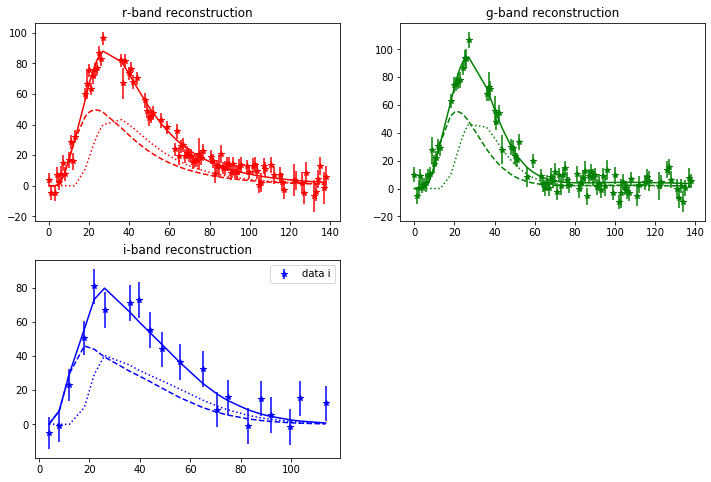

In [33]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=7, SystemNo=37790873 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn37790873_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn37790873_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn37790873_band_ztfi


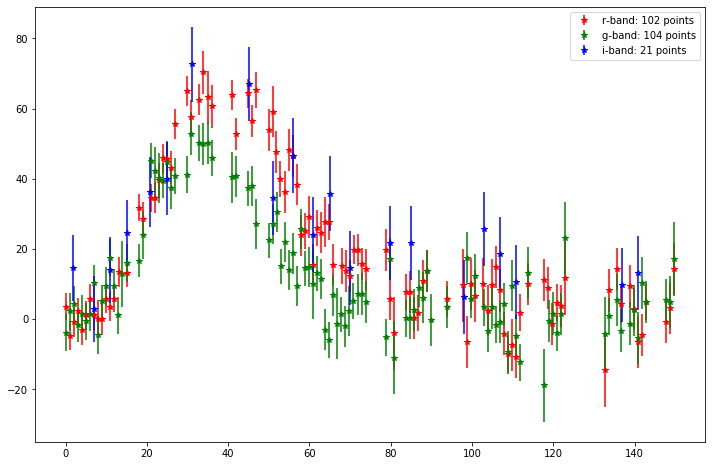

          td         x         y        mu     sysno  imno
0   0.000000  0.477828 -0.935136  1.801999  37790873     0
1  13.964194 -0.045801  0.331604 -2.229120  37790873     1

Relative magnification, mu= 1.2370261727521843 time delay dt= 13.964194244917536 


100%|██████████| 100000/100000 [1:12:01<00:00, 23.14it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 27 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 7831.36605216  5844.77269514  9505.03531954  4496.06641143
  6451.5347433  10775.31239814 11371.75495032 10783.40022321
 11149.92060752 11406.57156688  5711.80870092  5009.52164144
  7769.66915371 11232.68190939 11112.30932112 11113.66872869
 11382.43814524 10868.69368672  9617.199398    9139.1851176
  8175.86538489 11086.48844354 11553.84140252 10588.23414468
 11233.22500677 11091.14968046  6123.8117246 ]
[[Variables]]
    mu1:        0.68462010 +/- 0.25242127 (36.87%) (init = 1)
    dt1:        14.0508550 +/- 1.96525522 (13.99%) (init = 5)
    t0:         0 (fixed)
    nr:         1.89111925 +/- 0.72036752 (38.09%) (init = 1)
    tkr:        0.46819569 +/- 0.05827004 (12.45%) (init = 0.1)
    sr:         0.79608725 +/- 0.18116557 (22.76%) (init = 0.01)
    c0r:        1663.04536 +/- 15671.8568 (942.36%) (init = 1)
    c

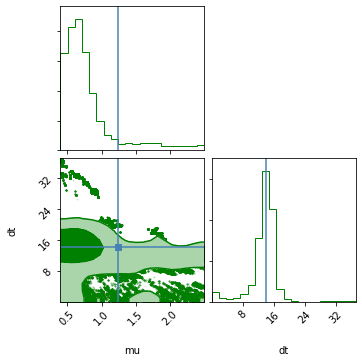


Maximum likelihood Estimation
-----------------------------


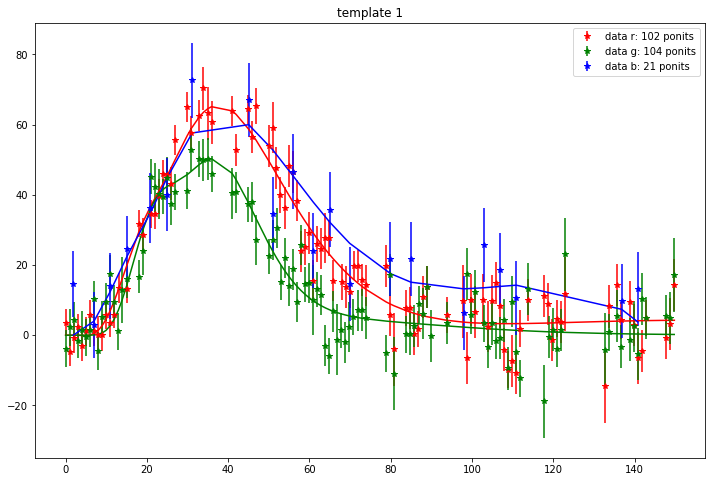

Maximum liklihood: mu= 0.7603734137582201 dt= 15.410871867895583

Chi^2 r= 109.75457894134499 Chi^2 g= 117.07513396886712 Chi^2 i= 14.707048918040144
data points::: r-band: 102  g-band: 104  i-band: 21


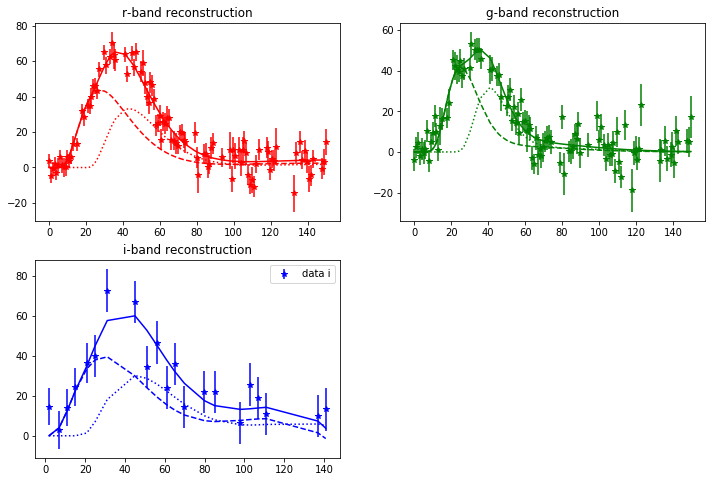

In [34]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=8, SystemNo=39087310 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn39087310_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn39087310_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn39087310_band_ztfi


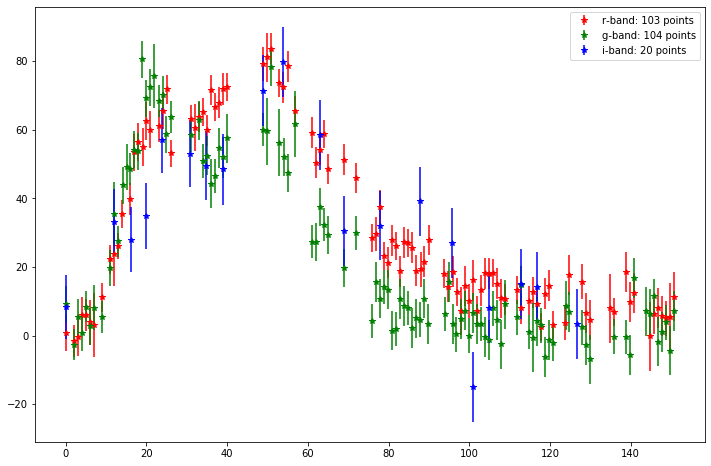

          td         x         y        mu     sysno  imno
0   0.000000  0.366549 -0.875110  1.368625  39087310     0
1  25.396588 -0.202215  0.068404 -1.166968  39087310     1

Relative magnification, mu= 0.8526573064036972 time delay dt= 25.396587917485533 


100%|██████████| 100000/100000 [1:06:50<00:00, 24.94it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 27 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 8662.40923864  6209.51530865 10181.74326954  9257.42459093
  2552.96052525 12190.70873701 12854.43365179 11552.28504145
 12416.22574379 12474.89468528  5474.90688689  8159.72609502
  7198.5492417  10858.12483537 12536.52943268 11023.87461351
 11730.15310614 12519.99298747 10547.98919737  8937.08714828
  8506.50085567 11500.02831297 12591.88276322 11361.23932975
 11305.53451994 12742.24398795  7224.53614323]
[[Variables]]
    mu1:        1.26950851 +/- 0.86223158 (67.92%) (init = 1)
    dt1:        3.61904342 +/- 3.51215528 (97.05%) (init = 5)
    t0:         0 (fixed)
    nr:         1.21940535 +/- 0.72519140 (59.47%) (init = 1)
    tkr:        0.84624950 +/- 0.16010025 (18.92%) (init = 0.1)
    sr:         0.96658733 +/- 0.01586242 (1.64%) (init = 0.01)
    c0r:        16159.1581 +/- 95541.9784 (591.26%) (init = 1)
    c

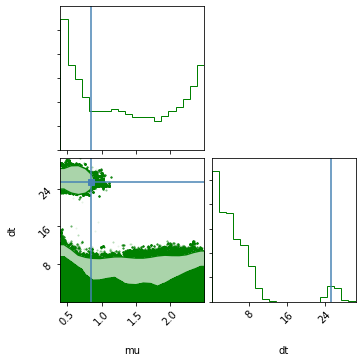


Maximum likelihood Estimation
-----------------------------


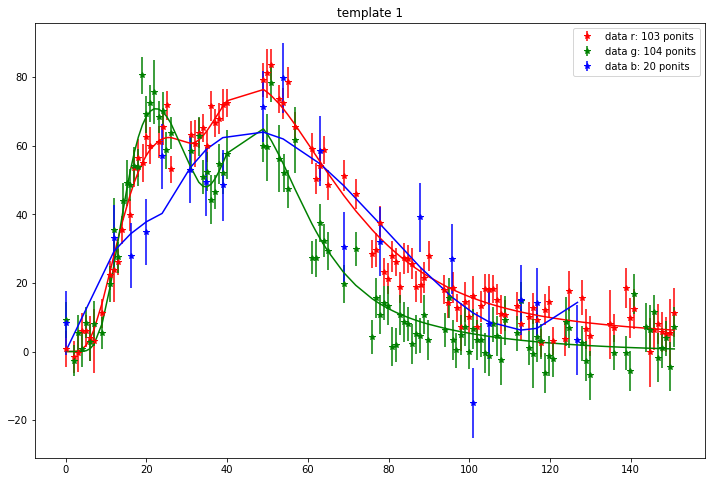

Maximum liklihood: mu= 0.6811413676535776 dt= 25.87872703470701

Chi^2 r= 97.77241053343086 Chi^2 g= 114.98177272822542 Chi^2 i= 26.55666414908428
data points::: r-band: 103  g-band: 104  i-band: 20


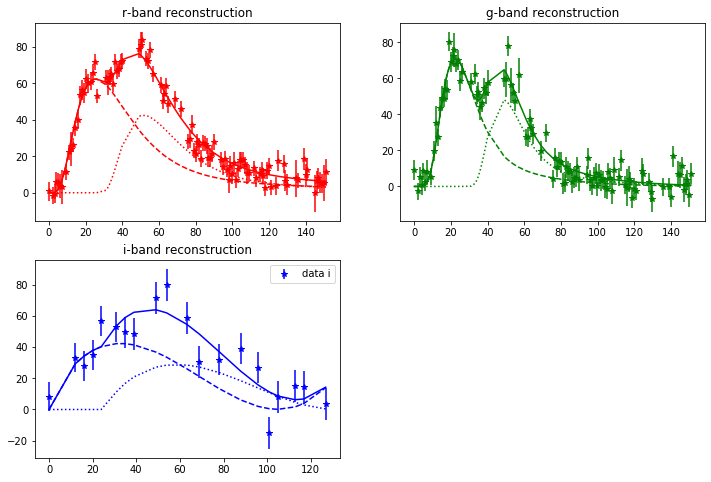

In [35]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1


Starting i=9, SystemNo=40221141 

../read_data/ztf-1a/ztf-1a_stackedflux_sysn40221141_band_ztfr
../read_data/ztf-1a/ztf-1a_stackedflux_sysn40221141_band_ztfg
../read_data/ztf-1a/ztf-1a_stackedflux_sysn40221141_band_ztfi


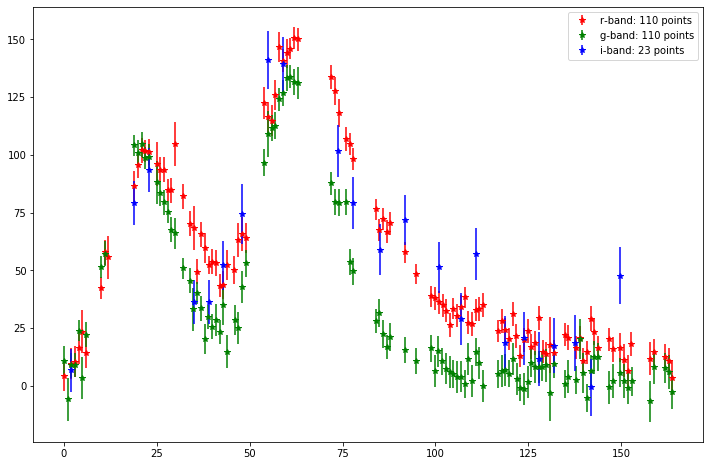

          td         x         y        mu     sysno  imno
0   0.000000  2.079878 -1.065848  2.157818  40221141     0
1  42.099531 -1.159171 -0.211248 -2.834009  40221141     1

Relative magnification, mu= 1.3133678212732556 time delay dt= 42.099531222904446 


100%|██████████| 100000/100000 [1:05:33<00:00, 25.42it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 24 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2000;
tau: [ 8590.39928976  5960.46755883 10499.41866001  7098.5970543
  1964.26399323 10303.12414956 10858.39118107  9687.62114776
 10957.52589912 10830.95821316 11395.59323431  9764.77144278
  1888.7192223  10140.95784899 11205.61640894 10241.54640415
 10903.96095283 10420.87953558  9205.12852716  6376.05738139
  9723.09404469 10714.21377964 10833.08054796 10284.49680659
 10829.40120283 10737.87009184   111.1359027 ]
[[Variables]]
    mu1:        1.75039717 +/- 0.76792875 (43.87%) (init = 1)
    dt1:        0.86894503 +/- 2.11737182 (243.67%) (init = 5)
    t0:         0 (fixed)
    nr:         2.14085852 +/- 0.64836225 (30.29%) (init = 1)
    tkr:        1.34183547 +/- 0.15911223 (11.86%) (init = 0.1)
    sr:         0.98799037 +/- 0.00379419 (0.38%) (init = 0.01)
    c0r:        97153.7123 +/- 1300625.89 (1338.73%) (init = 1)
    

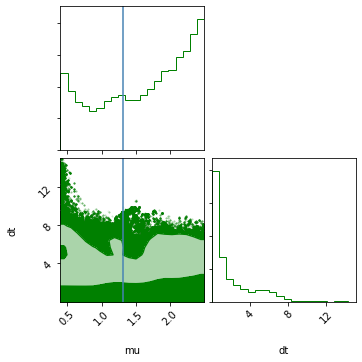


Maximum likelihood Estimation
-----------------------------


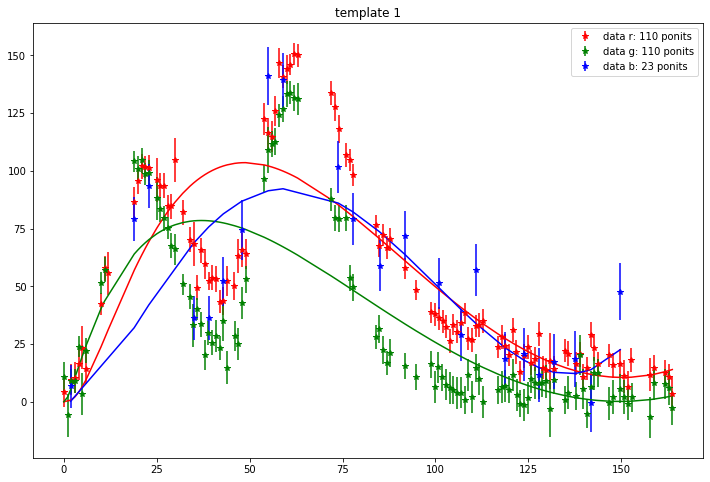

Maximum liklihood: mu= 2.2106731404422018 dt= 0.12019701097201296

Chi^2 r= 2107.222466442174 Chi^2 g= 2366.9679833512228 Chi^2 i= 137.71676460719323
data points::: r-band: 110  g-band: 110  i-band: 23


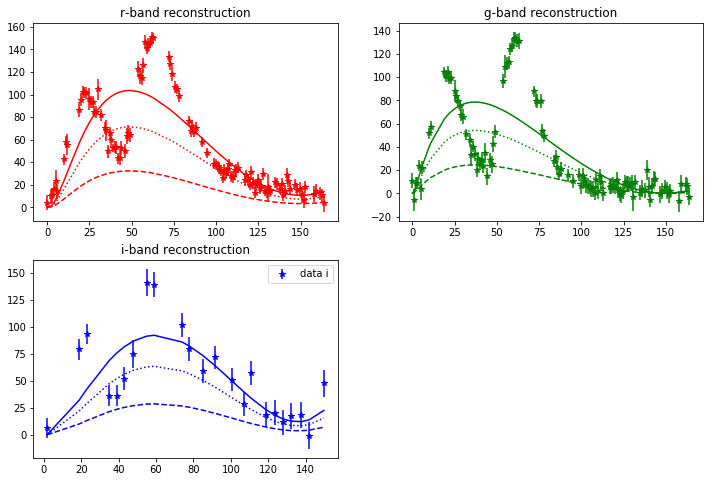

In [36]:
if(i>=Nsys):
    print("i==Nsys, last system_no studied")
    sys.exit()

sysn=sys_no_list[i]
print("\nStarting i=%d, SystemNo=%s \n"%(i,sysn))
[tr,fr,sigfr,tg,fg,sigfg,ti,fi,sigfi,mu_des,dt_des]=read_data(sysn)
results[i]=fitting(sysn,step,burn,thin,nwalker)
i=i+1